In [1]:
import os, shutil
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import random
import metrics

from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
import numpy as np


random.seed(1)

/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/orobix/opt/anaconda3/envs/tesi/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/orobix/opt/anaconda3/envs/tesi

In [2]:
CT = '../Data/CT/'
MRI = '../Data/MRI/'
PET = '../Data/PET/'

myPaths = [CT, MRI, PET]
myDict = {CT:[], MRI:[], PET:[]}

#creo il dizionario con le liste delle immagini
for path in myPaths:
    myDict[path] = [f for f in listdir(path) if isfile(join(path, f))]

#split train test (0.7 con data augmentation, 0.8 altrimenti)
split_at = 0.7

CT_train, CT_test = train_test_split(myDict[myPaths[0]], train_size=split_at)
MRI_train, MRI_test = train_test_split(myDict[myPaths[1]], train_size=split_at)
PET_train, PET_test = train_test_split(myDict[myPaths[2]], train_size=split_at)

#split train validation
#CT_train, CT_validation = train_test_split(CT_train, train_size=split_at)
#MRI_train, MRI_validation = train_test_split(MRI_train, train_size=split_at)
#PET_train, PET_validation = train_test_split(PET_train, train_size=split_at)

#print(train_file_names)

In [3]:
#data
print('Creo la directory data/ in questa posizione:', os.getcwd())

directories = ['data/train/', 
               #'data/validation', 
               'data/test/']

#cancello directory precedente per evitare errori
if os.path.exists('data/'):
    shutil.rmtree('data/', ignore_errors=False) 

#creo le direcotories data/train, data/test
for directory in directories:
        os.makedirs(directory)

Creo la directory data/ in questa posizione: /Users/orobix/Documents/Thesis/Source/Code


In [4]:
scans = ['CT', 'MRI', 'PET']

#copio le immagini di train in data/train
for source,scan in zip(myPaths, scans):
    train_files = eval(scan+'_train')
    for f in train_files:
        shutil.copy(source+f, directories[0])
        
#copio le immagini di test in data/test
for source,scan in zip(myPaths, scans):
    test_files = eval(scan+'_test')
    for f in test_files:
        shutil.copy(source+f, directories[1])
print("Dati trasferiti con successo in data/train e data/test.")

#uncomment if you want unbalanced dataset
#train_file_names = CT_train + MRI_train + PET_train
#test_file_names = CT_test + MRI_test + PET_test

#comment if you want unbalanced dataset
minimum_len = min(len(CT_train),len(MRI_train),len(PET_train))        
train_file_names = CT_train[0:minimum_len] + MRI_train[0:minimum_len] + PET_train[0:minimum_len]
test_file_names = CT_test[0:minimum_len] + MRI_test[0:minimum_len] + PET_test[0:minimum_len]

print("Number of images before data augmentation. Training:", len(train_file_names), " Test:", len(test_file_names))

Dati trasferiti con successo in data/train e data/test.
Number of images before data augmentation. Training: 594  Test: 321


## Data augmentation on train database

In [5]:
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util
from skimage import io

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

def vertical_flip(image_array: ndarray):
    # vertical flip
    return image_array[::-1, :]

def blured_image(image_array: ndarray):
    return ndimage.uniform_filter(original_image, size=(11, 11, 1))

In [6]:
import random
import os

# our folder path containing some images
folder_path = 'data/train'

# the number of file to generate
num_files_desired = len(train_file_names)*2


# loop on all files of the folder and build a list of files paths
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip}

for i in range(num_files_desired):
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = sk.io.imread(image_path)
    
    # random num of transformations to apply
    num_transformations_to_apply = random.randint(1, len(available_transformations))

    # choose a random transformation to apply for a single image
    key = random.choice(list(available_transformations))
    transformed_image = available_transformations[key](image_to_transform)
    
    # define a name for our new file
    new_file_path = '%s_augmented_image_%s.png' % (image_path.split('.')[0], i)
    
    # write image to the disk
    sk.io.imsave(new_file_path, transformed_image)
    
    #from IPython.core.debugger import set_trace
    #set_trace()

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

## Converto le immagini nella cartella train in tensori e li concateno

In [7]:
from skimage import io
import matplotlib.pyplot as plt
import cv2

# lista per fare image reading
final_train_file_names = [os.path.join(directories[0], f) for f in os.listdir(directories[0]) if os.path.isfile(os.path.join(directories[0], f))]
final_test_file_names = [os.path.join(directories[1], f) for f in os.listdir(directories[1]) if os.path.isfile(os.path.join(directories[1], f))]

print("Database dimension after data augmentation. Training:", len(final_train_file_names), " Test:", len(final_test_file_names))

Database dimension after data augmentation. Training: 1932  Test: 321


### x

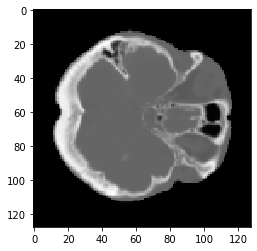

In [8]:
#x_train
x_train = io.imread(final_train_file_names[random.randint(0,9)])
x_train = cv2.resize(x_train, dsize=(128,128))
plt.imshow(x_train, cmap=plt.cm.gray)

#stack images
for img in final_train_file_names[1:]: #parti dalla seconda immagine
    img = io.imread(img)
    img = cv2.resize(img, dsize=(128,128))
    x_train = np.dstack((x_train,img))

x_train = np.rollaxis(x_train,-1) #(182,218,N)->(N,182,218)
#print('x_train shape:',x_train.shape)
    

#x_test
x_test = io.imread(final_test_file_names[random.randint(0,9)])
x_test = cv2.resize(x_test, dsize=(128,128))
plt.imshow(x_test, cmap=plt.cm.gray)

#stack images
for img in final_test_file_names[1:]: #parti dalla seconda immagine
    img = io.imread(img)
    img = cv2.resize(img, dsize=(128,128))
    x_test = np.dstack((x_test,img))

x_test = np.rollaxis(x_test,-1) #(182,218,N)->(N,182,218)
#print('x_test shape:',x_test.shape)

### y

In [9]:
#make labels y for metrics: CT==0, MRI==1, PET==2
ext = '.png'
y_train = []
for text in listdir('data/train'):
    fileNameOnly = text[:text.find(ext)]
    y_train.append(''.join([i for i in fileNameOnly if not i.isdigit()]))
for i, item in enumerate(y_train):
    if item == 'CT':
        y_train[i] = 0
    elif item == 'MRI':
        y_train[i] = 1
    else: y_train[i] = 2        

#make labels y for metrics: CT==0, MRI==1, PET==2
ext = '.png'
y_test = []
for text in listdir('data/test'):
    fileNameOnly = text[:text.find(ext)]
    y_test.append(''.join([i for i in fileNameOnly if not i.isdigit()]))
for i, item in enumerate(y_test):
    if item == 'CT':
        y_test[i] = 0
    elif item == 'MRI':
        y_test[i] = 1
    else: y_test[i] = 2  
#print(y_train)

In [10]:
#x = np.concatenate((x_train,x_test))
#y = np.concatenate((y_train,y_test))

x_test = x_test.reshape(x_test.shape + (1,))
x_test = x_test/255.

x = np.concatenate((x_train,))      
y = np.concatenate((y_train,))

x = x.reshape(x.shape + (1,))
x = x/255.
print('x shape:', x.shape)
print('y shape:', y.shape)

#numero di clusters. (3)
n_clusters = len(np.unique(y))
print('Number of categories:', n_clusters)

x shape: (1932, 128, 128, 1)
y shape: (1932,)
Number of categories: 3


## Pretrain a convolutional autoencoder

In [11]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [12]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

### Modello AE Conv2D_1

In [24]:
def autoencoderConv2D_1(input_shape=(128, 128, 1), filters=[32, 64, 128, 256]):
    input_img = Input(shape=input_shape)
    if input_shape[0] % 8 == 0:
        pad3 = 'same'
    else:
        pad3 = 'valid'
    x = Conv2D(filters[0], 5, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)

    x = Conv2D(filters[1], 5, strides=2, padding='same', activation='relu', name='conv2')(x)

    x = Conv2D(filters[2], 3, strides=2, padding=pad3, activation='relu', name='conv3')(x)

    x = Flatten()(x)
    encoded = Dense(units=filters[3], name='embedding')(x)
    x = Dense(units=filters[2]*int(input_shape[0]/8)*int(input_shape[0]/8), activation='relu')(encoded)

    x = Reshape((int(input_shape[0]/8), int(input_shape[0]/8), filters[2]))(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding=pad3, activation='relu', name='deconv3')(x)

    x = Conv2DTranspose(filters[0], 5, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 5, strides=2, padding='same', name='deconv1')(x)
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [25]:
autoencoder, encoder = autoencoderConv2D_1()
autoencoder.summary()

Model: "AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        832       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        51264     
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 128)       73856     
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
embedding (Dense)            (None, 256)               8388864   
_________________________________________________________________
dense_2 (Dense)              (None, 32768)             8421376  

### Pretrain


In [26]:
#hyperparameters (to edit)
dims = [x.shape[-1], 500, 500, 2000, 3]

init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')

pretrain_optimizer = SGD(lr=1, momentum=0.9)

pretrain_epochs = 100
batch_size = 64

save_dir = './results'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

### Conv_1

tensorboard --logdir=/tmp/autoencoder



In [ ]:
from keras.callbacks import TensorBoard

autoencoder.compile(optimizer='adadelta', loss='mse')

autoencoder.fit(x, 
                x, 
                batch_size=batch_size, 
                epochs=pretrain_epochs, 
                validation_data=(x_test, x_test),
                #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]
               )

autoencoder.save_weights(save_dir+'/conv_ae_weights.h5')

Train on 1932 samples, validate on 321 samples
Epoch 1/100
1932/1932 [==============================] - 28s 14ms/step - loss: 0.0726 - val_loss: 0.0576
Epoch 2/100
1932/1932 [==============================] - 26s 14ms/step - loss: 0.0572 - val_loss: 0.0573
Epoch 3/100
1932/1932 [==============================] - 26s 14ms/step - loss: 0.0568 - val_loss: 0.0570
Epoch 4/100
1932/1932 [==============================] - 26s 14ms/step - loss: 0.0558 - val_loss: 0.0542
Epoch 5/100
1932/1932 [==============================] - 26s 14ms/step - loss: 0.0320 - val_loss: 0.0175
Epoch 6/100
1932/1932 [==============================] - 26s 14ms/step - loss: 0.0227 - val_loss: 0.0261
Epoch 7/100
1932/1932 [==============================] - 29s 15ms/step - loss: 0.0194 - val_loss: 0.0123
Epoch 8/100
1932/1932 [==============================] - 28s 14ms/step - loss: 0.0160 - val_loss: 0.0209
Epoch 9/100
1932/1932 [==============================] - 32s 17ms/step - loss: 0.0146 - val_loss: 0.0094
Epoch 10

Epoch 78/100
1932/1932 [==============================] - 28s 14ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 79/100
1932/1932 [==============================] - 28s 15ms/step - loss: 0.0045 - val_loss: 0.0028
Epoch 80/100
1932/1932 [==============================] - 29s 15ms/step - loss: 0.0043 - val_loss: 0.0040
Epoch 81/100
1932/1932 [==============================] - 27s 14ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 82/100
1932/1932 [==============================] - 26s 14ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 83/100
1932/1932 [==============================] - 27s 14ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 84/100
1932/1932 [==============================] - 27s 14ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 85/100
1932/1932 [==============================] - 27s 14ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 86/100
 512/1932 [======>.......................] - ETA: 18s - loss: 0.0037

In [18]:
autoencoder.load_weights(save_dir+'/conv_ae_weights.h5')

In [19]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input,outputs=[clustering_layer, autoencoder.output])

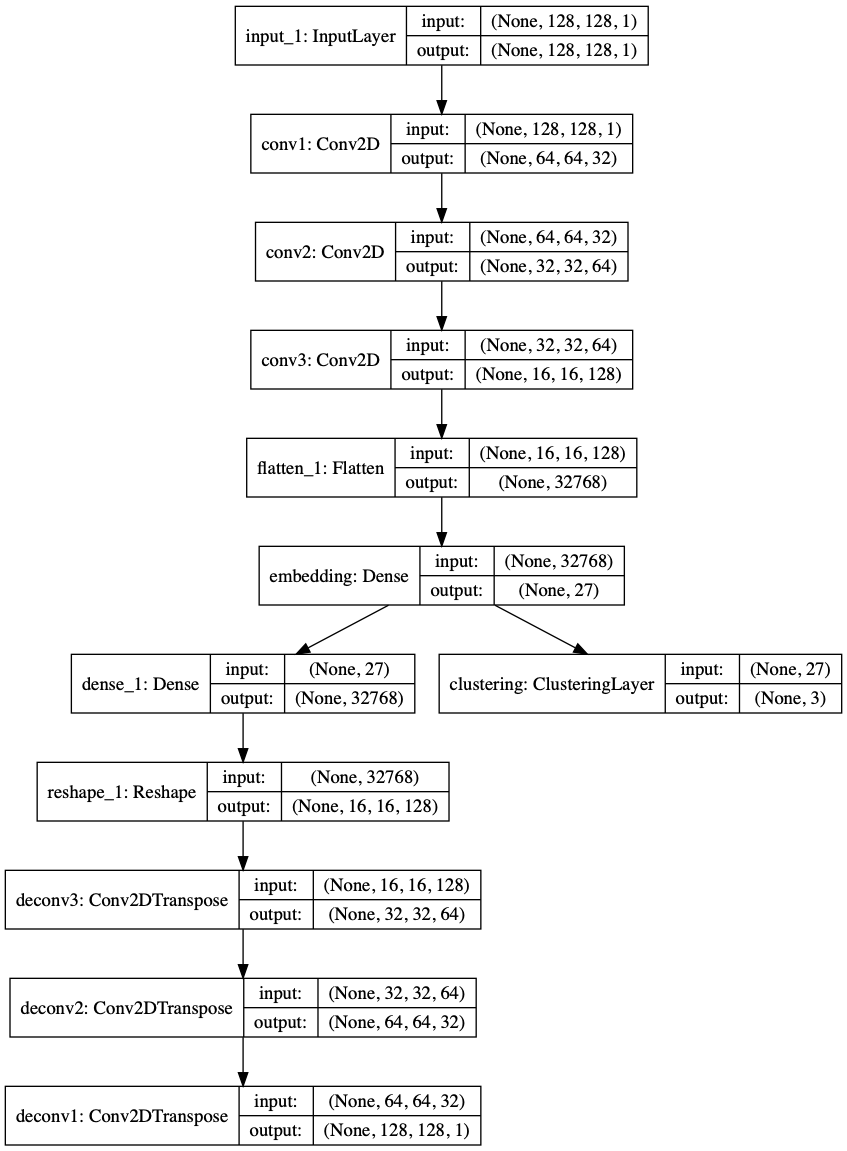

In [20]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')

In [21]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x))
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
y_pred_last = np.copy(y_pred)

In [22]:
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 1], optimizer='adam')

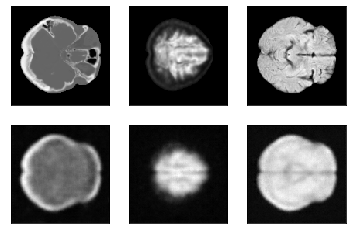

In [23]:
n=3
decoded_imgs = autoencoder.predict(x_test)

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Deep clustering

In [ ]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

loss = 0
index = 0
maxiter = 1400
update_interval = 140
index_array = np.arange(x.shape[0])

tol = 0.00001 # tolerance threshold to stop training

## Training

In [ ]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc = np.round(metrics.acc(y, y_pred), 5)
            nmi = np.round(metrics.nmi(y, y_pred), 5)
            ari = np.round(metrics.ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc, nmi, ari), ' ; loss=', loss)

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=[p[idx], x[idx]])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + '/b_DEC_model_final.h5')

In [ ]:
model.load_weights(save_dir + '/b_DEC_model_final.h5')

In [ ]:
#eval
q, _ = model.predict(x, verbose=0)
p = target_distribution(q)  # update the auxiliary target distribution p

# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc = np.round(metrics.acc(y, y_pred), 5)
    nmi = np.round(metrics.nmi(y, y_pred), 5)
    ari = np.round(metrics.ari(y, y_pred), 5)
    loss = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc, nmi, ari), ' ; loss=', loss)

In [ ]:
#confusion matrix
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)

confusion_matrix = sklearn.metrics.confusion_matrix([int(i) for i in y], y_pred)

plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

In [ ]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
ind